# 2023-01-30

In [32]:
from typing import List, Union
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
from abc import ABC, abstractmethod

import random

In [42]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(max(0, self.data), (self,), 'ReLU')

        def _backward():
            self.grad += (self.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [10]:
x = -1

x if x > 0 else 0

0

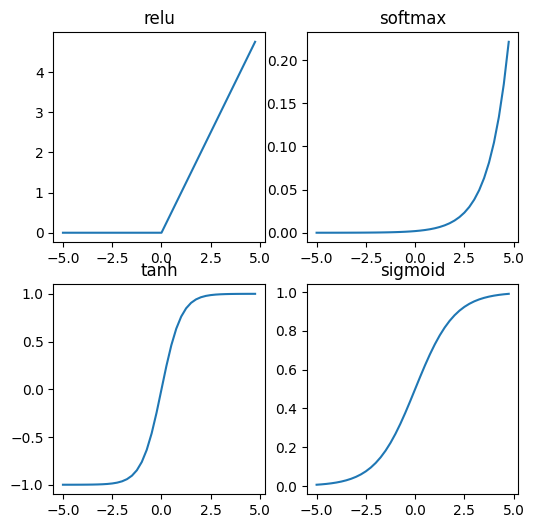

In [11]:
x = np.arange(-5, 5, 0.25)

def relu(x):
    return x * (x > 0)

def softmax(x):
    return np.exp(x) / np.exp(x).sum()

def tanh(x):
    return np.tanh(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.plot(x, relu(x))
plt.title('relu')

plt.subplot(2, 2, 2)
plt.plot(x, softmax(x))
plt.title('softmax')

plt.subplot(2, 2, 3)
plt.plot(x, tanh(x))
plt.title('tanh')

plt.subplot(2, 2, 4)
plt.plot(x, sigmoid(x))
plt.title('sigmoid')
plt.show()

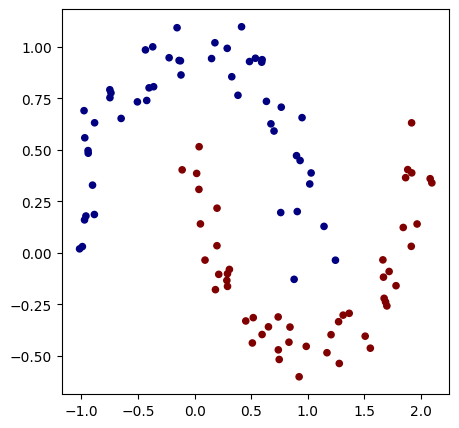

In [135]:
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [136]:
X.shape, y.shape

((100, 2), (100,))

In [74]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [75]:
model = MLP(2, [16, 16, 1]) # 2-hiine layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [76]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337
step 0 loss 0.719798003336533, accuracy 70.0%
step 1 loss 0.7058861925725594, accuracy 71.0%
step 2 loss 0.6923678283520208, accuracy 71.0%
step 3 loss 0.6790477344448579, accuracy 71.0%
step 4 loss 0.6661110877864228, accuracy 71.0%
step 5 loss 0.6532107723361325, accuracy 71.0%
step 6 loss 0.6403834855431145, accuracy 71.0%
step 7 loss 0.6277987653115149, accuracy 70.0%
step 8 loss 0.6165678269795075, accuracy 72.0

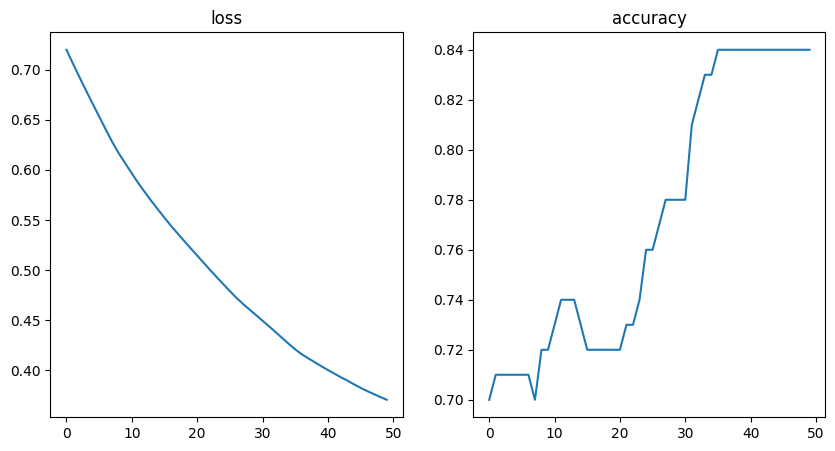

In [91]:
model = MLP(2, [16, 16, 1]) # 2-hiine layer neural network
print(model)
print("number of parameters", len(model.parameters()))

# optimization loop

loss_data: List[float] = []
acc_data: List[float] = []

for k in range(50):
    
    # forward
    total_loss, acc = loss()
    loss_data.append(total_loss.data)
    acc_data.append(acc)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1e-2
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_data)
plt.title('loss')
plt.subplot(1, 2, 2)
plt.plot(acc_data)
plt.title('accuracy')
plt.show()

### Training with batch size 2 and lr that is too high

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337
step 0 loss 0.49869706910383754, accuracy 100.0%
step 1 loss 0.5199859736595178, accuracy 50.0%
step 2 loss 0.4888225222590697, accuracy 100.0%
step 3 loss 0.528478379357271, accuracy 50.0%
step 4 loss 0.6876141638659437, accuracy 50.0%
step 5 loss 0.9805022082669628, accuracy 100.0%
step 6 loss 0.9923016541134798, accuracy 50.0%
step 7 loss 0.8058518170645986, accuracy 100.0%
step 8 loss 0.9508224699000546, accuracy

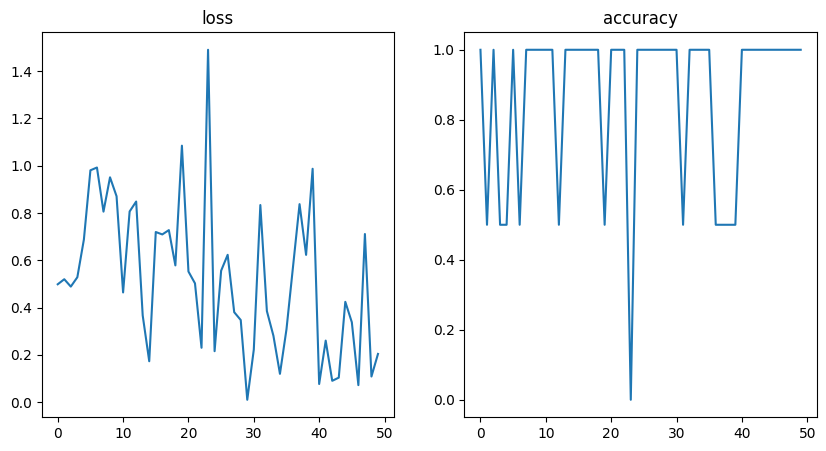

In [92]:
model = MLP(2, [16, 16, 1]) # 2-hidden layer neural network
print(model)
print("number of parameters", len(model.parameters()))

# optimization loop

loss_data: List[float] = []
acc_data: List[float] = []

for k in range(50):
    
    # forward
    total_loss, acc = loss(batch_size=2)
    loss_data.append(total_loss.data)
    acc_data.append(acc)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1e-2
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_data)
plt.title('loss')
plt.subplot(1, 2, 2)
plt.plot(acc_data)
plt.title('accuracy')
plt.show()

In [83]:
X.shape

100

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337
step 0 loss 1.0164988469076202, accuracy 50.0%
step 1 loss 0.5270449361595436, accuracy 50.0%
step 2 loss 0.10249486754820668, accuracy 100.0%
step 3 loss 0.5160330611308118, accuracy 50.0%
step 4 loss 2.476169910862772, accuracy 50.0%
step 5 loss 0.7242065987503319, accuracy 50.0%
step 6 loss 0.009908619043469364, accuracy 100.0%
step 7 loss 0.7608778339482686, accuracy 50.0%
step 8 loss 2.7061110096662273, accuracy

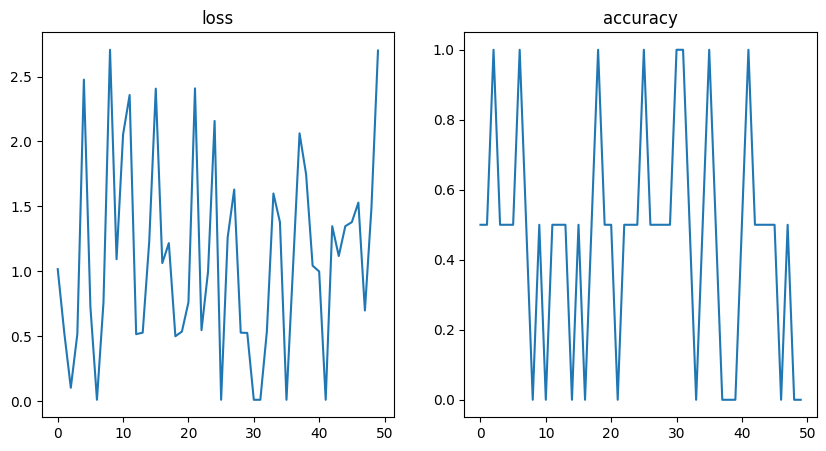

In [93]:
model = MLP(2, [16, 16, 1]) # 2-hiine layer neural network
print(model)
print("number of parameters", len(model.parameters()))

# optimization loop

loss_data: List[float] = []
acc_data: List[float] = []

for k in range(50):
    
    # forward
    total_loss, acc = loss(batch_size=2)
    loss_data.append(total_loss.data)
    acc_data.append(acc)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 2e-10
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_data)
plt.title('loss')
plt.subplot(1, 2, 2)
plt.plot(acc_data)
plt.title('accuracy')
plt.show()

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337
step 0 loss 1.2520223572579503, accuracy 32.0%
step 1 loss 1.3136205919283557, accuracy 24.0%
step 2 loss 1.2513960789071648, accuracy 28.000000000000004%
step 3 loss 1.1727149360100577, accuracy 36.0%
step 4 loss 1.14253955401188, accuracy 24.0%
step 5 loss 1.0371329168722525, accuracy 48.0%
step 6 loss 1.072651217655021, accuracy 32.0%
step 7 loss 1.0219121934575681, accuracy 44.0%
step 8 loss 1.026019383270039, ac

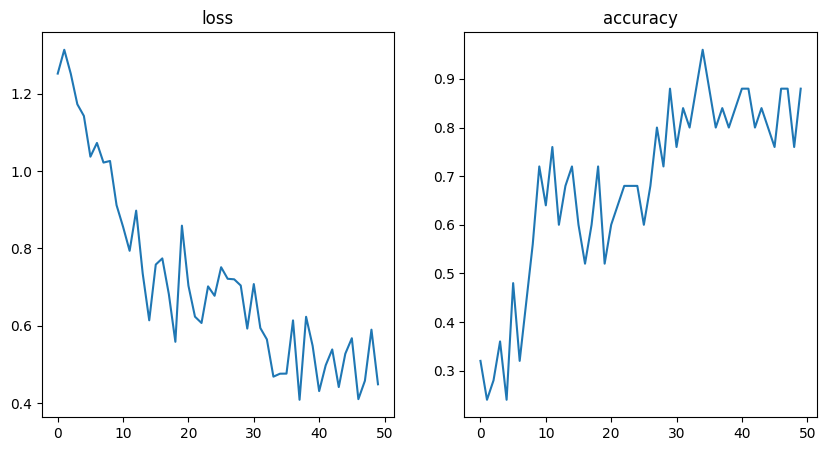

In [95]:
model = MLP(2, [16, 16, 1]) # 2-hiine layer neural network
print(model)
print("number of parameters", len(model.parameters()))

# optimization loop

loss_data: List[float] = []
acc_data: List[float] = []

for k in range(50):
    
    # forward
    total_loss, acc = loss(batch_size=25)
    loss_data.append(total_loss.data)
    acc_data.append(acc)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 2e-2
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_data)
plt.title('loss')
plt.subplot(1, 2, 2)
plt.plot(acc_data)
plt.title('accuracy')
plt.show()

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337
step 0 loss 2.386364329787672, accuracy 20.0%
step 1 loss 2.4394391913438387, accuracy 16.0%
step 2 loss 1.8983210836813509, accuracy 28.000000000000004%
step 3 loss 2.019530994332312, accuracy 20.0%
step 4 loss 1.8497527452754408, accuracy 20.0%
step 5 loss 1.7112317874383594, accuracy 28.000000000000004%
step 6 loss 1.6023283243384017, accuracy 26.0%
step 7 loss 1.3242524928733126, accuracy 42.0%
step 8 loss 1.3045

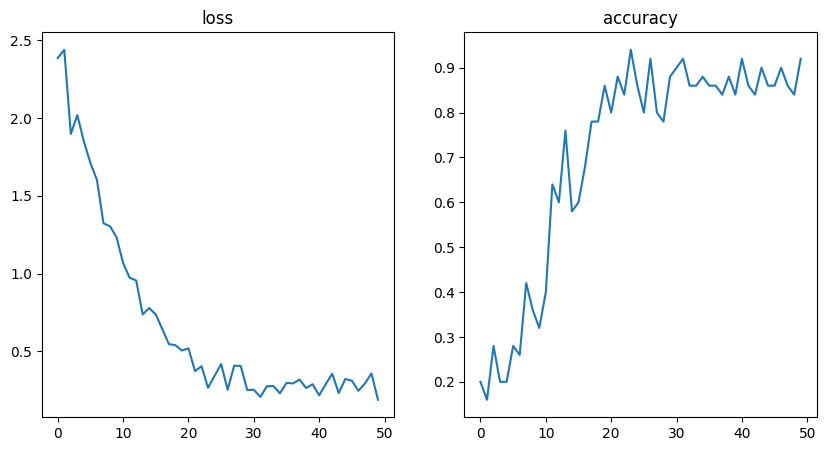

In [96]:
model = MLP(2, [16, 16, 1]) # 2-hiine layer neural network
print(model)
print("number of parameters", len(model.parameters()))

# optimization loop

loss_data: List[float] = []
acc_data: List[float] = []

for k in range(50):
    
    # forward
    total_loss, acc = loss(batch_size=50)
    loss_data.append(total_loss.data)
    acc_data.append(acc)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 2e-2
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_data)
plt.title('loss')
plt.subplot(1, 2, 2)
plt.plot(acc_data)
plt.title('accuracy')
plt.show()

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337
step 0 loss 0.9378909264070562, accuracy 46.666666666666664%
step 1 loss 0.8868155583135185, accuracy 50.66666666666667%
step 2 loss 0.7824481174002392, accuracy 58.666666666666664%
step 3 loss 0.6778412119912381, accuracy 66.66666666666666%
step 4 loss 0.743076574649458, accuracy 65.33333333333333%
step 5 loss 0.7088286037878537, accuracy 66.66666666666666%
step 6 loss 0.6654082532773069, accuracy 68.0%
step 7 loss 

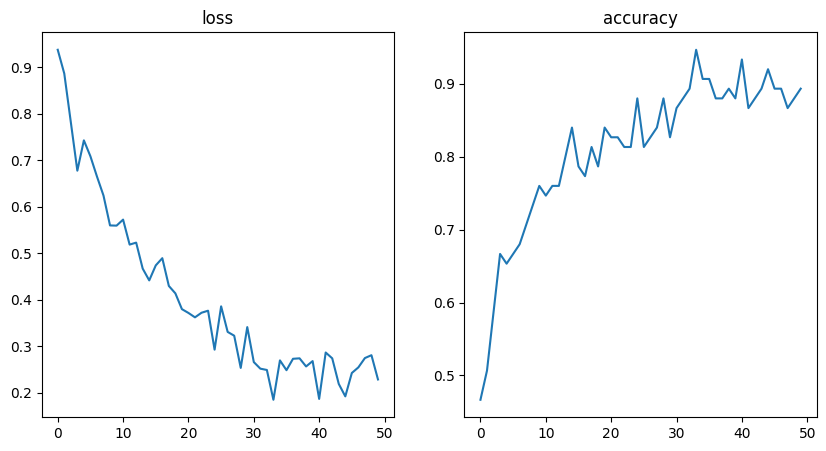

In [97]:
model = MLP(2, [16, 16, 1]) # 2-hiine layer neural network
print(model)
print("number of parameters", len(model.parameters()))

# optimization loop

loss_data: List[float] = []
acc_data: List[float] = []

for k in range(50):
    
    # forward
    total_loss, acc = loss(batch_size=75)
    loss_data.append(total_loss.data)
    acc_data.append(acc)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 2e-2
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_data)
plt.title('loss')
plt.subplot(1, 2, 2)
plt.plot(acc_data)
plt.title('accuracy')
plt.show()

(-1.773402026796518, 2.226597973203482)

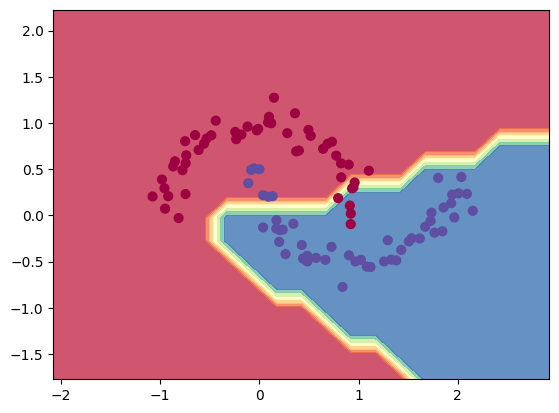

In [98]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337
step 0 loss 0.7013655456614346, accuracy 75.0%
step 1 loss 0.5409224927724205, accuracy 75.0%
step 2 loss 1.095434942315317, accuracy 50.0%
step 3 loss 0.673519583651411, accuracy 87.5%
step 4 loss 0.3463826799626617, accuracy 87.5%
step 5 loss 0.9931350795268745, accuracy 75.0%
step 6 loss 0.6978225552804901, accuracy 75.0%
step 7 loss 0.2822073050551695, accuracy 75.0%
step 8 loss 0.7676214047590959, accuracy 75.0%

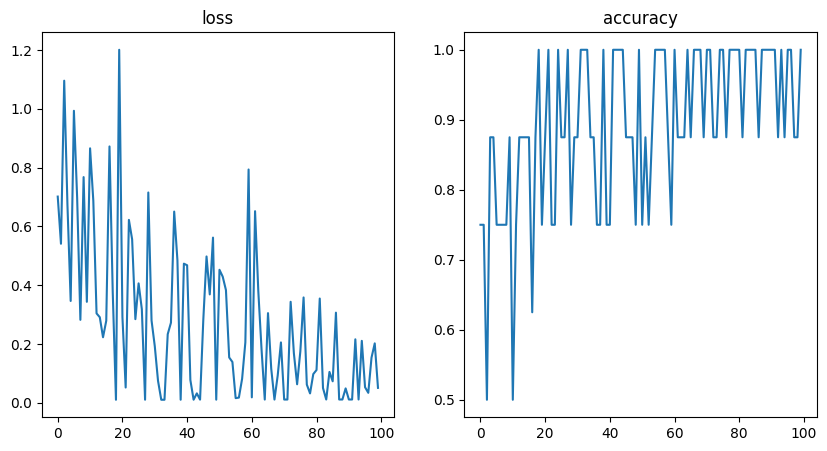

In [101]:
model = MLP(2, [16, 16, 1]) # 2-hiine layer neural network
print(model)
print("number of parameters", len(model.parameters()))

# optimization loop

loss_data: List[float] = []
acc_data: List[float] = []

for k in range(100):
    
    # forward
    total_loss, acc = loss(batch_size=8)
    loss_data.append(total_loss.data)
    acc_data.append(acc)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_data)
plt.title('loss')
plt.subplot(1, 2, 2)
plt.plot(acc_data)
plt.title('accuracy')
plt.show()

(-1.773402026796518, 2.226597973203482)

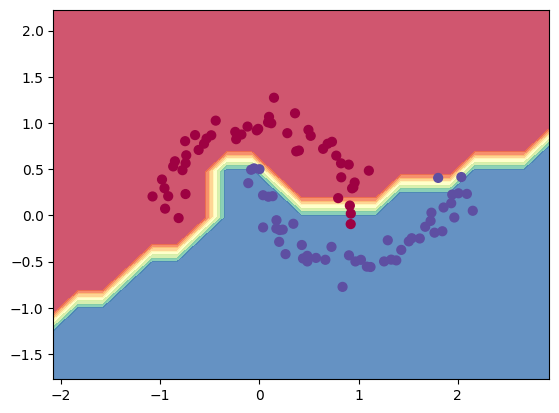

In [102]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [157]:
from sklearn.datasets import load_diabetes

X = load_diabetes().data
y = load_diabetes().target
y = y > 100
y = y*2 - 1 # make y be -1 or 1


In [160]:
X = X.reshape(10, 442)

MLP of [Layer of [ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 465
step 0 loss 1.0376321488756275, accuracy 60.0%
step 1 loss 1.086367501132389, accuracy 70.0%
step 2 loss 0.8929026144022991, accuracy 70.0%
step 3 loss 0.6592878302443664, accuracy 70.0%
step 4 loss 0.9027441007142124, accuracy 80.0%
step 5 loss 0.6164450365321757, accuracy 70.0%
step 6 loss 0.8375954801412772, accuracy 70.0%
step 7 loss 0.7202627199085803, accuracy 70.0%
step 8 loss 0.828621951893981

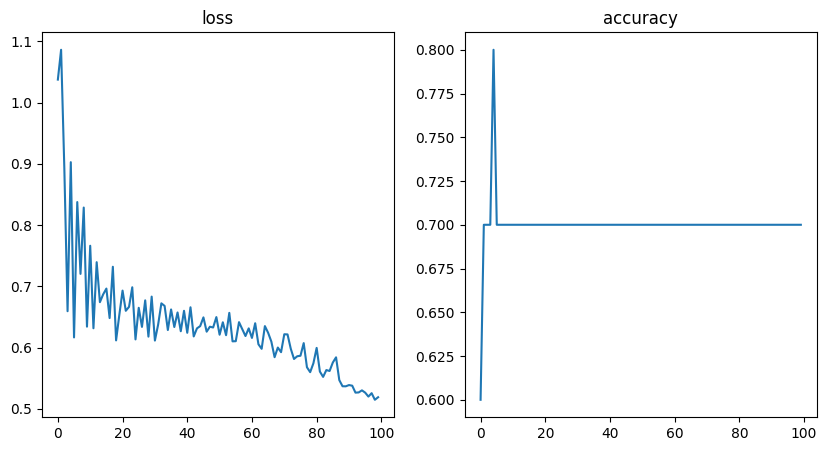

In [162]:
model = MLP(10, [16, 16, 1]) # 2-hiine layer neural network
print(model)
print("number of parameters", len(model.parameters()))

# optimization loop

loss_data: List[float] = []
acc_data: List[float] = []

for k in range(100):
    
    # forward
    total_loss, acc = loss(batch_size=32)
    loss_data.append(total_loss.data)
    acc_data.append(acc)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_data)
plt.title('loss')
plt.subplot(1, 2, 2)
plt.plot(acc_data)
plt.title('accuracy')
plt.show()

## Dropout

![](https://miro.medium.com/max/640/1*wDGvx0z0-nEB8zQHykvwPw.webp)

![](https://miro.medium.com/max/640/1*DNewrtjKh8F2uK0TwE8C4A.webp)

![](https://miro.medium.com/max/402/1*6zbHNtrOopvWm3a_yBlbvw.webp)

In [224]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin: int, nout: int, dropout: float = 0.0,  **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]
        self.dropout = dropout
        self.training = True

    def __call__(self, x):
        if self.training and self.dropout > 0:
            mask = np.random.binomial(1, 1 - self.dropout, len(self.neurons))
            out = [n(x*drop) for n, drop in zip(self.neurons, mask)]
        elif not self.training and self.dropout > 0:
            out = [n(list(np.array(x)*self.dropout)) for n in self.neurons]
        else:
            out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts, dropouts: List[float] = []):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1, dropout=dropouts[i]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

## Loading data once more


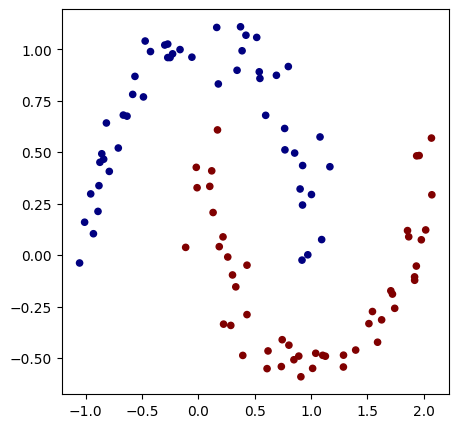

In [225]:
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(

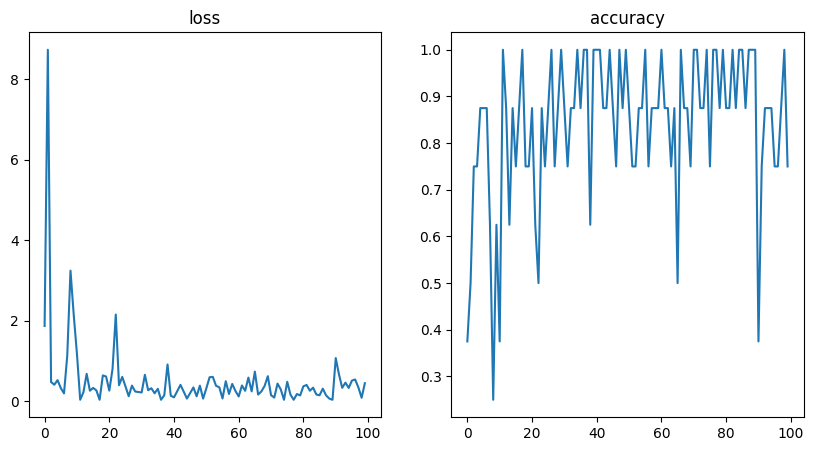

In [226]:
model = MLP(2, [32, 32, 1], dropouts=[0, 0, 0, 0]) # 2-hiine layer neural network
print(model)
print("number of parameters", len(model.parameters()))

# optimization loop

loss_data: List[float] = []
acc_data: List[float] = []

for k in range(100):
    
    # forward
    total_loss, acc = loss(batch_size=8)
    loss_data.append(total_loss.data)
    acc_data.append(acc)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_data)
plt.title('loss')
plt.subplot(1, 2, 2)
plt.plot(acc_data)
plt.title('accuracy')
plt.show()

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(

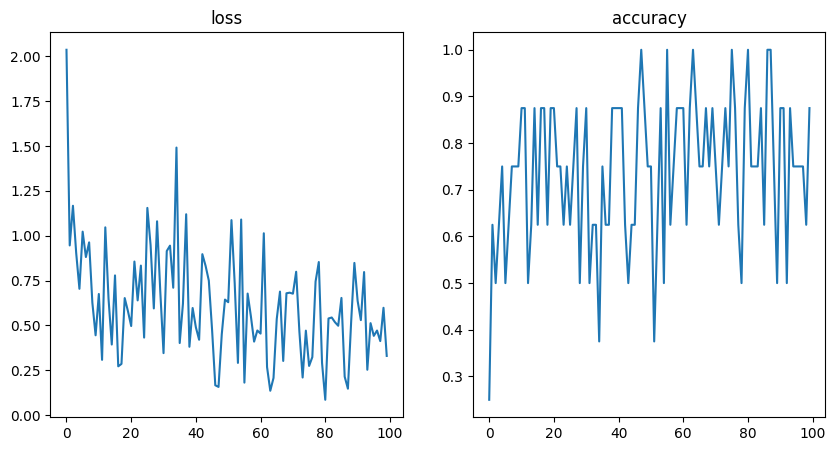

In [227]:
model = MLP(2, [32, 32, 1], [0.3, 0.3, 0.3, 0]) # 2-hiine layer neural network
print(model)
print("number of parameters", len(model.parameters()))

# optimization loop

loss_data: List[float] = []
acc_data: List[float] = []

for k in range(100):
    
    # forward
    total_loss, acc = loss(batch_size=8)
    loss_data.append(total_loss.data)
    acc_data.append(acc)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_data)
plt.title('loss')
plt.subplot(1, 2, 2)
plt.plot(acc_data)
plt.title('accuracy')
plt.show()

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(

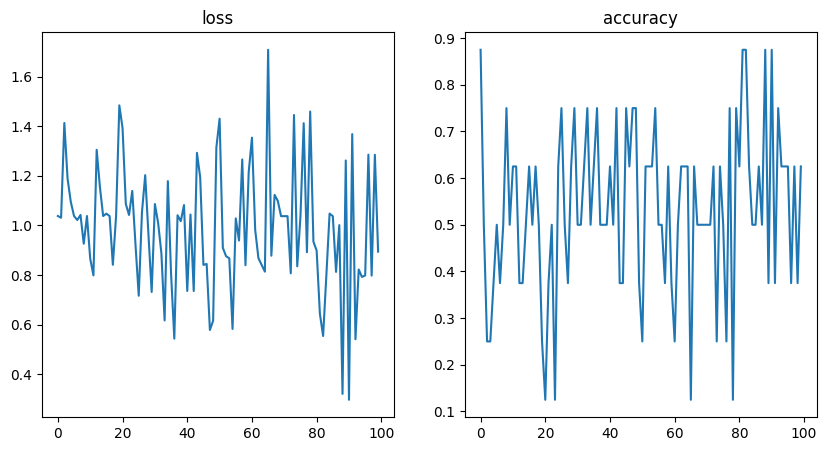

In [228]:
model = MLP(2, [32, 32, 1], [0.9, 0.9, 0.9, 0]) # 2-hiine layer neural network
print(model)
print("number of parameters", len(model.parameters()))

# optimization loop

loss_data: List[float] = []
acc_data: List[float] = []

for k in range(100):
    
    # forward
    total_loss, acc = loss(batch_size=8)
    loss_data.append(total_loss.data)
    acc_data.append(acc)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_data)
plt.title('loss')
plt.subplot(1, 2, 2)
plt.plot(acc_data)
plt.title('accuracy')
plt.show()

In [229]:
model([1, 2])

Value(data=0.9874890365081168, grad=-0.2498079480059649)

In [230]:
for layer in model.layers:
    layer.training = False
model([1, 2])

Value(data=-3.342118599105212, grad=0)

In [231]:
import torch

/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [254]:
m = torch.nn.Dropout(p=0.9)
input = torch.randn(2, 3)
output = m(input)
output

tensor([[-0., -0., 0.],
        [-0., -0., 0.]])

In [255]:
from torch import nn
from torch.nn import functional as F

In [256]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, p=0.5):
      super(NeuralNet, self).__init__()
      self.fc1 = nn.Linear(input_size, hidden_size)
      self.fc2 = nn.Linear(hidden_size, hidden_size)
      self.fc3 = nn.Linear(hidden_size, num_classes)
      self.dropout = nn.Dropout(p) 

  def forward(self, x):
      out = F.relu(self.fc1(x))
      out = F.relu(self.fc2(out))
      out = self.dropout(self.fc3(out))
      return out

In [294]:
import torch
import torch.nn  as nn

m = nn.Dropout(p=0.1)
input = torch.randn(20, 16)
print(torch.sum(torch.nonzero(input)))
print(torch.sum(torch.nonzero(m(input))))

m = nn.Dropout(p=0.5)
input = torch.randn(16, 2)

print(torch.sum(torch.nonzero(input)))
print(torch.sum(torch.nonzero(m(input))))

tensor(5440)
tensor(4831)
tensor(256)
tensor(134)
